In [342]:
import pandas as pd
import xarray as xr
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import os
from PIL import Image
import glob
sns.set_theme(style="whitegrid")

In [1]:
pacifica = [(-122.4886322, 37.6772991),
    (-122.5037384, 37.6762122),
    (-122.5435638, 37.6000882),
    (-122.5009918, 37.5810450),
    (-122.4824524, 37.6071601),
    (-122.4838257, 37.6463157),
    (-122.4886322, 37.6778426)]

balinas = [(-122.7145386, 37.9111589),
    (-122.7282715, 37.8884023),
    (-122.6513672, 37.8710593),
    (-122.6074219, 37.8575072),
    (-122.5778961, 37.8721433),
    (-122.6589203, 37.9160343),
    (-122.7131653, 37.9127841)]

in_bay = [
    (-122.5277710, 37.8287685),
    (-122.5037384, 37.7766850),
    (-122.3986816, 37.7962206),
    (-122.4179077, 37.8656387),
    (-122.4879456, 37.8477481),
    (-122.5112915, 37.8390723),
    (-122.5270844, 37.8298532)]


In [3]:
poly_pacifica = Polygon(pacifica)
poly_balinas = Polygon(balinas)
poly_bay = Polygon(in_bay)

In [174]:
crs = {'init': 'epsg:4326'}
d = {'box': ['balinas', 'pacifica','in_bay'], 'geometry': [poly_balinas,poly_pacifica,poly_bay]}
polygons = gpd.GeoDataFrame(d, crs=crs)

/home/pdaniel/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [220]:
ds = xr.open_dataset("../DailyModelRuns/model_output/concave_hrf_20210207T164400_continuous.nc")

In [221]:
start_time = ds['time'].values[0]
t = ds['time'].values[4*36]
df = ds['status'].to_dataframe()
time_df = ds['time'].to_pandas().dt.strftime('%Y%m%d')

In [222]:
step_df = df.query("time == @t")
step_df = step_df.reset_index('time',drop=True).query("status >= 0")
points = gpd.GeoDataFrame(
        step_df, geometry=gpd.points_from_xy(step_df.lon, step_df.lat),crs=crs)

/home/pdaniel/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


box                                                   balinas
geometry    POLYGON ((-122.7145386 37.9111589, -122.728271...
Name: 0, dtype: object

<AxesSubplot:>

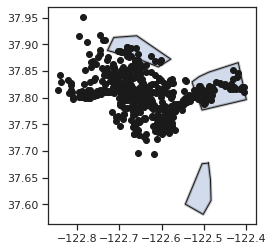

In [366]:
polygons.plot(ax=ax, alpha=.25,lw=3,edgecolor='k')
polygons.plot(ax=ax,lw=1,edgecolor='k',facecolor='None')
points.plot(ax=ax,color='k')

In [272]:
in_bay = []
in_pacifica = []
in_balinas = []
time = []
total = []

for j, t in enumerate(tqdm(pd.to_datetime(ds['time'].values))):
    step_df = df.query("time == @t").reset_index('time',drop=True).query("status >= 0")
    total.append(len(step_df))
    points = gpd.GeoDataFrame(
            step_df, geometry=gpd.points_from_xy(step_df.lon, step_df.lat),crs=crs)
    in_balinas.append(points.within(polygons.loc[0, 'geometry']).sum())
    in_pacifica.append(points.within(polygons.loc[1, 'geometry']).sum())
    in_bay.append(points.within(polygons.loc[2, 'geometry']).sum())
    time.append(t)

d = {
    'time':time,
    'bay':in_bay,
    'pacifica':in_pacifica,
    'balinas':in_balinas,
    'num_part':total
}
df_locs = pd.DataFrame(d)

100%|██████████| 193/193 [00:06<00:00, 31.18it/s]


In [285]:
df_locs['bay_norm'] = df_locs['bay']/df_locs['num_part'] * 100
df_locs['pacifica_norm'] = df_locs['pacifica']/df_locs['num_part'] * 100
df_locs['balinas_norm'] = df_locs['balinas']/df_locs['num_part'] * 100

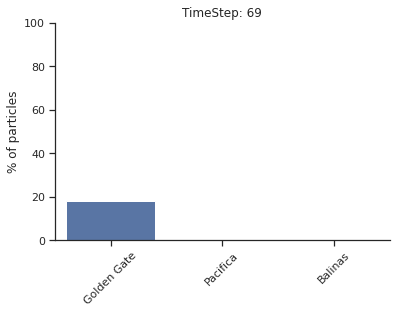

In [367]:
def make_bar_chart(df, index):   
    """Save a frame for to be patched for a gif"""
    sns.set_style("ticks")
    temp = pd.DataFrame(df.loc[index][['bay_norm','pacifica_norm','balinas_norm']])
    fig, ax = plt.subplots()
    sns.barplot(x=temp.index, y=index, data=temp,ax=ax)
    ax.set_ylabel("% of particles")
    ax.set_ylim(0,100)
    ax.set_xticklabels(['Golden Gate','Pacifica','Balinas'])
    ax.set_title("TimeStep: {}".format(temp.columns[0]))
    out_name = 'barplot-animation-frames/'+f'chart_frame_{index:03}.png'
    sns.despine()
    plt.xticks(rotation=45)

#     plt.savefig(out_name,dpi=300)
#     plt.close()
make_bar_chart(df_locs,69)


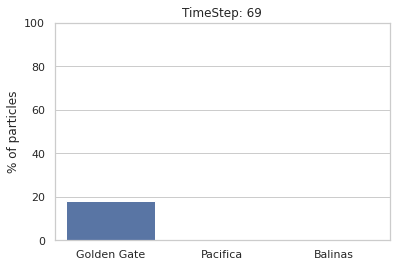

In [333]:
make_bar_chart(df_locs,69)
# [make_bar_chart(df_locs,i) for i in tqdm(range(len(df_locs)))];

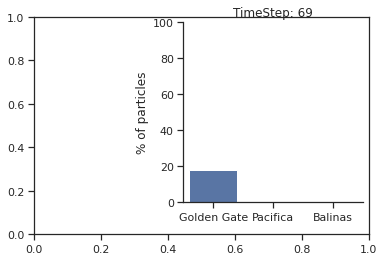

In [348]:
fig, ax = plt.subplots()
ax2 = inset_axes(ax, width=2.5, height=2.5)
sns.set_style("ticks")
temp = pd.DataFrame(df_locs.loc[69][['bay_norm','pacifica_norm','balinas_norm']])
sns.barplot(x=temp.index, y=69, data=temp,ax=ax2)
ax2.set_ylabel("% of particles")
ax2.set_ylim(0,100)
ax2.set_xticklabels(['Golden Gate','Pacifica','Balinas'])
ax2.set_title("TimeStep: {}".format(temp.columns[0]))
# out_name = 'barplot-animation-frames/'+f'chart_frame_{index:03}.png'
sns.despine(ax=ax2)

In [347]:
temp

,69
bay_norm,17.9657
pacifica_norm,0
balinas_norm,0


In [327]:
def build_gif(fp_out):
    fp_in = os.path.join("barplot-animation-frames","chart_frame_*png")
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
            save_all=True, duration=100, loop=0)

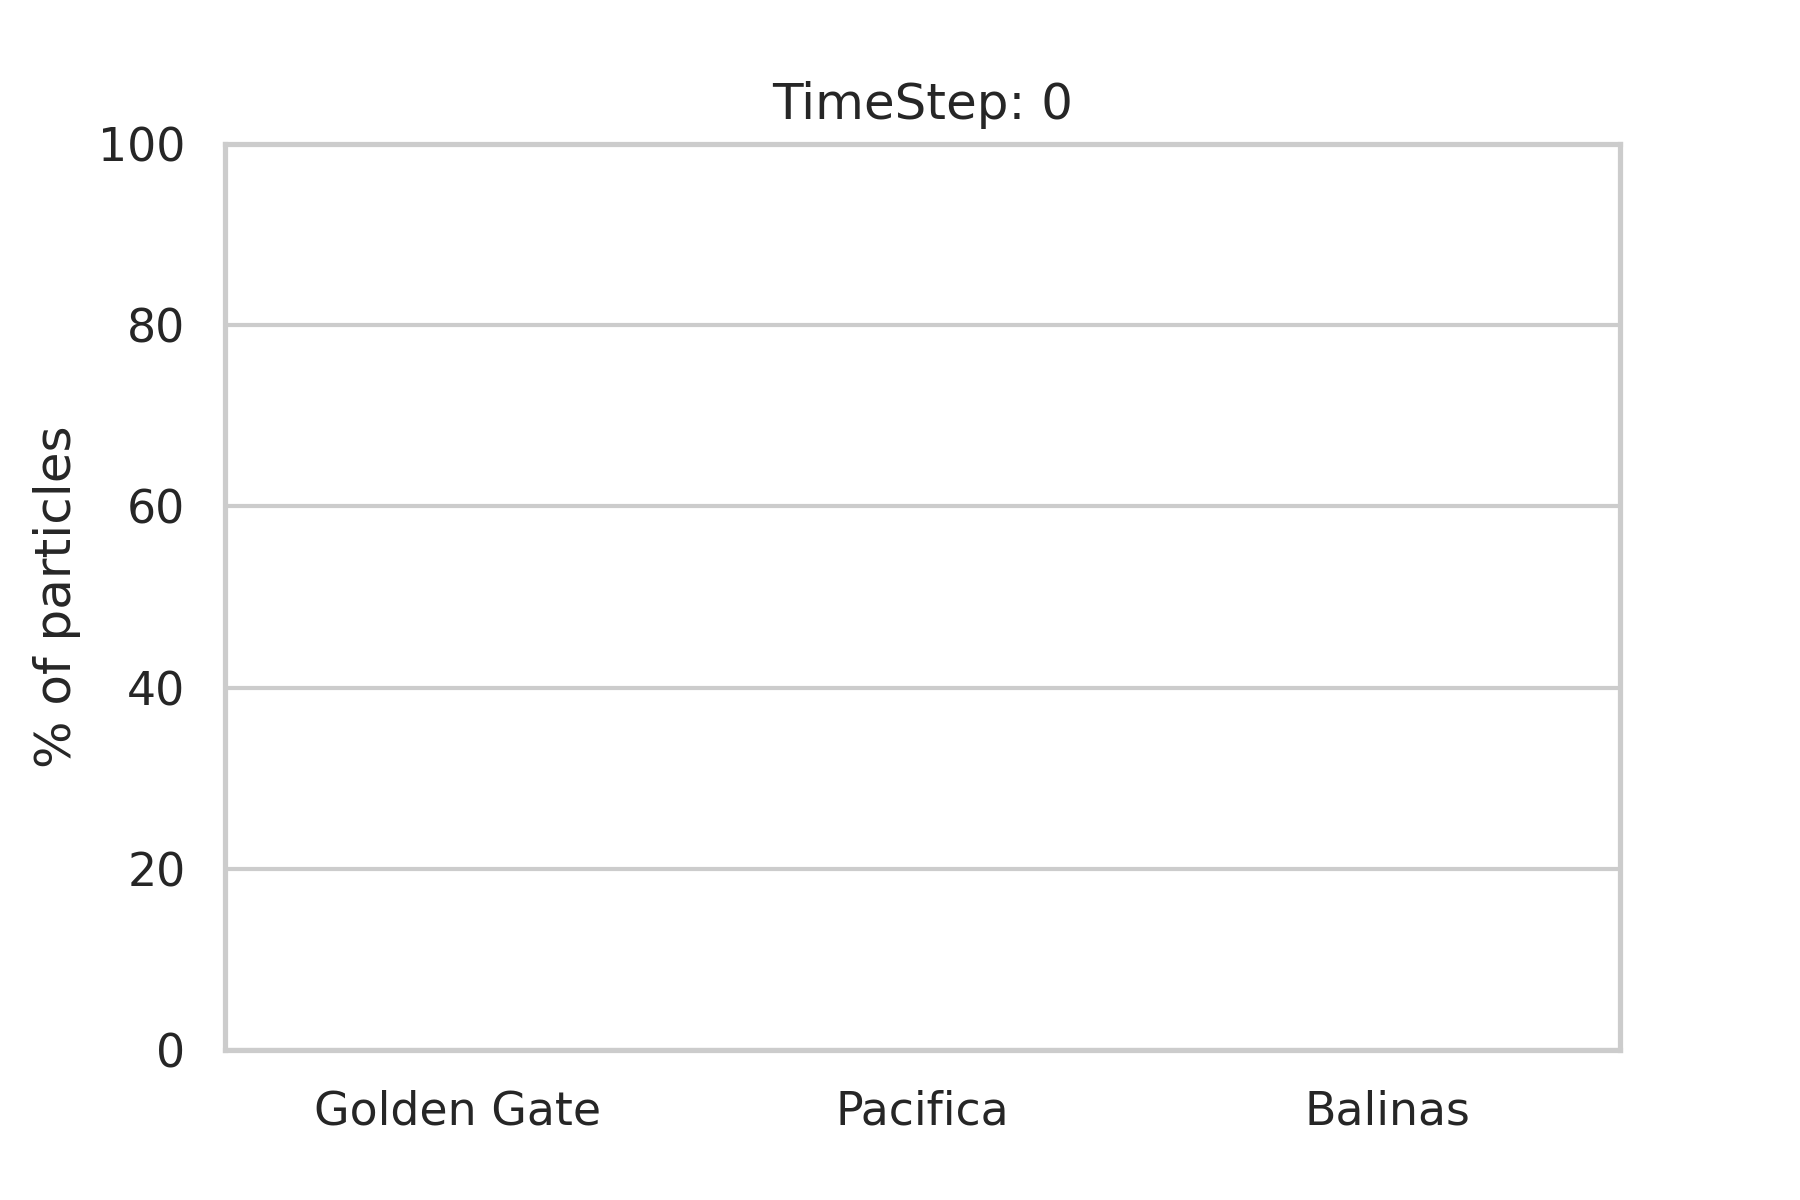

In [328]:
# build_gif("20210207T164400_bar.gif")

<img src="./20210207T164400_bar.gif">